In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# Importamos dataset de iris para clasificación
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.Series(iris.target)

In [3]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64

In [5]:
y.value_counts()

0    50
1    50
2    50
dtype: int64

In [6]:
# Agregamos columnas con 'ruido' (valores al azar), para que no sea tan perfecto
# agregamnos 800 columnas (sí.... es un ejemplo malvado)
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [7]:
X

array([[ 5.1       ,  3.5       ,  1.4       , ..., -1.07709907,
        -0.4246633 , -0.8299646 ],
       [ 4.9       ,  3.        ,  1.4       , ...,  1.4121517 ,
        -1.38043075, -0.53591456],
       [ 4.7       ,  3.2       ,  1.3       , ...,  0.65880214,
        -0.59691711, -0.22295918],
       ...,
       [ 6.5       ,  3.        ,  5.2       , ..., -0.5154906 ,
        -0.12964864, -0.5092809 ],
       [ 6.2       ,  3.4       ,  5.4       , ...,  1.42147798,
        -0.61336209, -0.34432031],
       [ 5.9       ,  3.        ,  5.1       , ...,  2.53170549,
        -0.03572203,  0.17320019]])

In [8]:
X.shape

(150, 804)

In [9]:
y.size

150

In [10]:
# Hacemnos la división entre train y test, asegurándonos de mezclar antes los datos,
# y estratificando por las clases por las dudas (aunque sabemos que las clases están balanceadas)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=0)

In [11]:
# Escalamos los datos, porque vamos a usar Regresión logística con regularización
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [12]:
# definimos 3 folds estratificados, para el cross-validation
kf = StratifiedKFold(n_splits = 3, random_state = 12, shuffle = True)

In [13]:
logit = LogisticRegression(multi_class =  'ovr', max_iter = 10000)

In [14]:
grilla = dict(penalty =  ['none', 'l1', 'l2'],
              C = [0.01, 0.1, 1, 10, 100],
             solver = ['saga'])

In [15]:
# usamos como scoring para estimar los hiperparámetros el área bajo la curva, tomando 
# para la clasificación 'ovr' (one versus rest), que es una de las maneras de transformar 
# una clasificación multiclase en n clasificaciones binaria, una para cada clase
# Podría tomar otra métrica, pero elegí esa para mostrar cómo la usamos
grid = GridSearchCV(estimator = logit, param_grid = grilla, cv = kf, scoring = 'roc_auc_ovr', n_jobs = -1)

In [16]:
grid.fit(X_train_sc, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2'], 'solver': ['saga']},
             scoring='roc_auc_ovr')

In [17]:
grid.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

In [18]:
y_train_pred =grid.predict(X_train_sc)

In [19]:
confusion_matrix(y_train, y_train_pred)

array([[35,  0,  0],
       [ 0, 29,  6],
       [ 0,  2, 33]])

In [20]:
y_test_pred = grid.predict(X_test_sc)

In [21]:
confusion_matrix(y_test, y_test_pred)

array([[15,  0,  0],
       [ 0,  7,  8],
       [ 0,  1, 14]])

In [22]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.47      0.61        15
           2       0.64      0.93      0.76        15

    accuracy                           0.80        45
   macro avg       0.84      0.80      0.79        45
weighted avg       0.84      0.80      0.79        45



In [23]:
# Para graficar la curva ROC, necesito hacer predict_proba
y_test_pred_proba = grid.predict_proba(X_test_sc)

In [24]:
# y_test_pred_proba tiene 3 columnas
#  y_test_pred_proba[0]: probabilidad de que la observación sea de la clase 0
#  y_test_pred_proba[1]: probabilidad de que la observación sea de la clase 1
#  y_test_pred_proba[2]: probabilidad de que la observación sea de la clase 2

# Vemos los 5 primeros registros
y_test_pred_proba[:5,]

array([[0.03300093, 0.19920199, 0.76779708],
       [0.05330244, 0.32614075, 0.62055682],
       [0.71368864, 0.25948403, 0.02682733],
       [0.81071771, 0.13792362, 0.05135867],
       [0.12394876, 0.4367801 , 0.43927114]])

In [25]:
# le digo que para el score multiclase, utilice 'ovr', y que haga macro average
roc_auc_score(y_test, y_test_pred_proba, multi_class = 'ovr', average = 'macro')

0.9422222222222222

In [26]:
# primeros 5 registros de y_test
y_test[:5]

136    2
142    2
39     0
44     0
50     1
dtype: int64

In [27]:
# Para graficar la curva ROC, voy a usar roc_curve
# Pero roc_curve sirve solamente para clasificación binaria
# Por lo tanto, voy a tener que usarlo sobre cada clasificador de una clase vs el resto
# Para lograr eso, tengo  que binarizar el target, y lo hago con label_binarize
# Esta operación puede asimilarse a lo que hacemos con get_dummies
# Es decir, si tenemos nuestro target
# y_test = [2, 2, 0, 0, 1] por ejemplo, label_binarize va a generar una 'variable dummy' por cada clase, y en cada
# observación pondrá 1 si la observación es de esa clase, o 0 si es de cualquier otra.
# Así, el y_test de nuestro ejemplo va a transformarse en una matriz del tipo:
#  clase0    clase1    clase2 
#    0         0         1
#    0         0         1
#    1         0         0
#    1         0         0
#    0         1         0
#

In [28]:
# Binarizo el target

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
len(y_test_bin[:,0])

45

In [29]:
len(y_test_pred_proba[:,0])

45

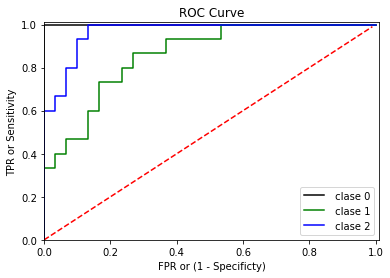

In [30]:
from sklearn.metrics import roc_curve

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('FPR or (1 - Specificty)'); plt.ylabel('TPR or Sensitivity'); plt.title('ROC Curve')
colors = ['black', 'green', 'blue']

for i in range(0, n_classes):
    fpr_roc,tpr_roc,thr_roc = roc_curve(y_test_bin[:,i], y_test_pred_proba[:,i])
    df = pd.DataFrame(dict(fpr=fpr_roc, tpr=tpr_roc, thr = thr_roc))
    plt.plot(df['fpr'],df['tpr'], label = f' clase {i}', color = colors[i])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = 'red', linestyle = '--')
plt.legend()
plt.show()